# Modelado

In [36]:
# --- Bibliotecas para Manipulación de Datos y Análisis ---
import pandas as pd  # Manipulación de datos
import numpy as np  # Cálculo numérico

# --- Reducción de Dimensionalidad ---
from sklearn.decomposition import PCA

# --- Bibliotecas para Modelos de Machine Learning ---
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import xgboost as xgb
from catboost import CatBoostClassifier

# --- Evaluación de Modelos ---
from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score,
    classification_report,
    mean_squared_error,
    accuracy_score,
    r2_score,
    mean_absolute_error
)

# --- Búsqueda de Hiperparámetros y Validación Cruzada ---
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline  # Creación de pipelines

# --- Trabajo con Imágenes y Visualización ---
from IPython.display import Image
import pydotplus
import graphviz
import matplotlib.pyplot as plt  # Visualización
import seaborn as sns

# --- Directorios del Sistema ---
import os

# --- Otras Bibliotecas ---
import joblib  # Serialización de modelos
import pprint

## Funciones para entrenamiento y testeo

In [37]:
def grid_search_function(model, param_grid, X_train, y_train, pca_components=[0.50, 0.99], cv=2):
    """
    Realiza una búsqueda en cuadrícula (grid search) con validación cruzada
    para encontrar los mejores parámetros de un modelo de aprendizaje automático.

    Parámetros:
    - model: El modelo de aprendizaje automático a utilizar.
    - param_grid (dict): Diccionario de parámetros a probar en la búsqueda en cuadrícula.
    - X_train (array-like): Datos de entrenamiento.
    - y_train (array-like): Etiquetas de entrenamiento.
    - pca_components (list, opcional): Lista de componentes principales (PCA) a probar.
      Predeterminado: [0.50, 0.99]
    - cv (int, opcional): Número de divisiones para la validación cruzada. Predeterminado: 2.

    Retorna:
    tuple: Una tupla que contiene los mejores parámetros, la mejor puntuación,
    el mejor estimador y los resultados de la validación cruzada.
    """
    # Configura el pipeline con las funciones de PCA y el modelo de aprendizaje automático
    pipeline = Pipeline([
        ('pca', PCA()),
        ('classify', model)
    ])

    # Realiza la búsqueda en cuadrícula con validación cruzada utilizando el pipeline anterior
    # y los parámetros del modelo específico
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Obtiene los mejores parámetros del modelo específico
    best_params = grid_search.best_params_

    # Elimina el prefijo 'classify__' de todas las claves
    best_params = {key.replace('classify__', '', 1): value for key, value in best_params.items()}

    return best_params

In [38]:
def train(model, best_params=None):
    """
    Entrena un modelo de aprendizaje automático, opcionalmente utilizando los mejores
    parámetros obtenidos de una búsqueda en cuadrícula (grid search).

    Parámetros:
    - model: El modelo de aprendizaje automático a entrenar.
    - best_params (dict, opcional): Diccionario con los mejores parámetros para el modelo.
      Si no se proporciona, se entrenará el modelo con los parámetros predeterminados.

    Retorna:
    - El modelo entrenado.
    """
    # Si se proporcionan los mejores parámetros, se establecen en el modelo
    if best_params is not None:
        model.set_params(**best_params)

    # Entrena el modelo con los datos de entrenamiento
    return model.fit(X_train, y_train)

In [39]:
def test(model, is_classification=False):
    """
    Evalúa el rendimiento de un modelo de aprendizaje automático en un conjunto de prueba.
    Puede manejar tanto modelos de clasificación como de regresión.

    Parámetros:
    - model: El modelo de aprendizaje automático a evaluar.
    - is_classification (bool, opcional): Indica si el modelo es de clasificación.
      Predeterminado: False (regresión).

    Retorna:
    - Un diccionario con las predicciones y el reporte de resultados.
    """
    # Realiza las predicciones del modelo en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Si el modelo es de clasificación, calcula métricas de clasificación
    if is_classification:
        report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
        report = report[['precision', 'recall', 'f1-score']]

        # Configuración de la figura
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.5]})

        # Dibuja la curva de precisión-recall
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax1)
        ax1.set_title("2-class Precision-Recall curve")

        # Mapa de calor de métricas
        sns.heatmap(report, annot=True, cmap='Blues', ax=ax2)
        ax2.set_title('Mapa de Calor de Métricas')

        plt.tight_layout()
        plt.show()

        return {"y_pred": y_pred, "report": report}

    # Si el modelo es de regresión, calcula métricas de regresión
    else:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        result_regression_report = {
            'Mean Absolute Error (MAE)': mae,
            'Mean Squared Error (MSE)': mse,
            'Root Mean Squared Error (RMSE)': rmse,
            'R² Score': r2
        }
        
        pprint.pprint(result_regression_report)
        
        return {"y_pred": y_pred, "report": result_regression_report}

### Importacion de datos

In [40]:
path_df_estandarizado_escalado = '../data/2_silver/df_estandarizado_escalado.csv'
df_estandarizado_escalado = pd.read_csv(path_df_estandarizado_escalado)

### Separacion de datos

In [41]:
# separo las las variables de la variable target
X = df_estandarizado_escalado.drop(columns=['subscription_status_encoded']).copy()
y = df_estandarizado_escalado['subscription_status_encoded'].copy()
# Divido las variable target y el resto de variables en testeo y prueba utilizando un 35% de datos para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Seleccion de caracteristicas

In [42]:
# Aplicar ANOVA para seleccionar el 60% de mejores características
selector = SelectKBest(score_func=f_classif, k=int(0.6 * df_estandarizado_escalado.columns.size))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
mask = selector.get_feature_names_out(input_features=X_train.columns)

In [43]:
# Crear un nuevo DataFrame solo con las columnas seleccionadas
X_train = pd.DataFrame(X_train_selected, columns=mask)
X_test = pd.DataFrame(X_test_selected, columns=mask)

### Instancia y evaluacion de modelos

### Decision tree

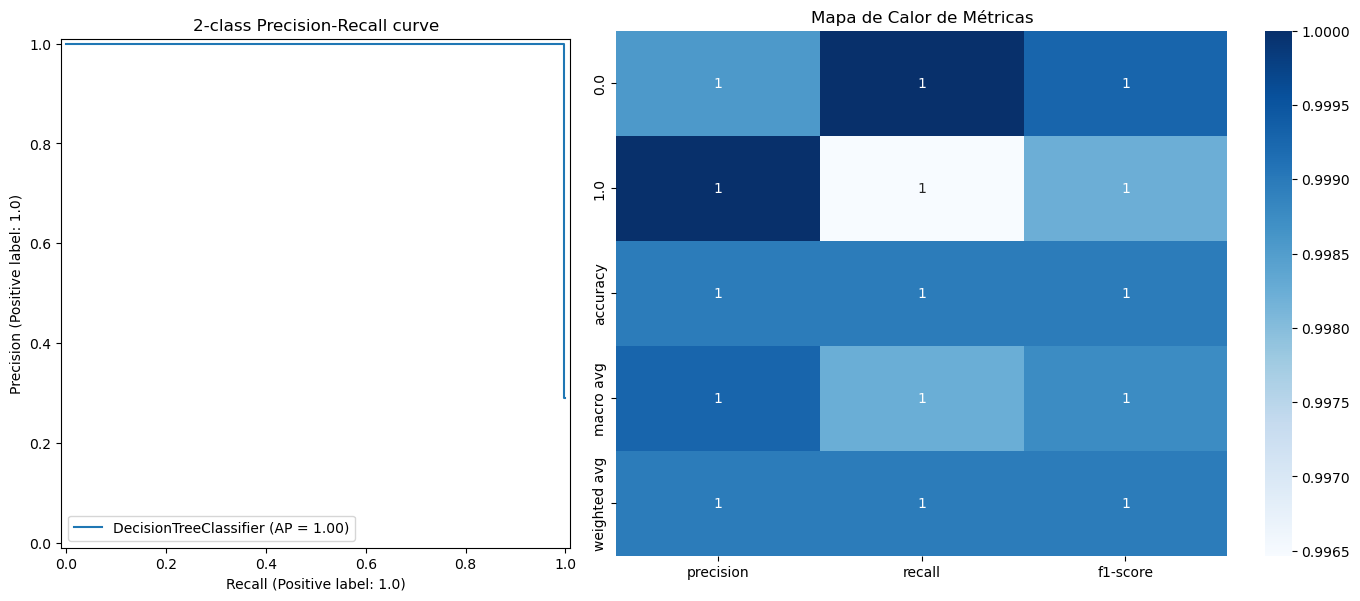

In [44]:
# Se implementara tambien, un modelo simple de arbol de desicion, debido a que si bien hay 10 veces mas registros que cantidad de columnas, no hay un exceso de los mismos
#y esto puede generar sobre ajuste en modelos complejos

# create decision tree model object by ModeloML class
decision_tree_model = DecisionTreeClassifier()

# params for decision tree model
decision_tree_model_params_grid = {
    'classify__max_depth': [None, 10, 20],  # Ajusta estos valores
    'classify__min_samples_split': [2, 5, 10],
    'classify__min_samples_leaf': [1, 2, 4]
}

#obtain best params grid to decision tree model using grid search
decision_tree_model_best_params_grid = grid_search_function(decision_tree_model, param_grid=decision_tree_model_params_grid, X_train=X_train, y_train=y_train)

# train decision tree model with best params
decision_tree_model = train(decision_tree_model, decision_tree_model_best_params_grid)

# test decision tree model
y_pred, report = test(decision_tree_model, is_classification=True)

### Logistic regression

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packa

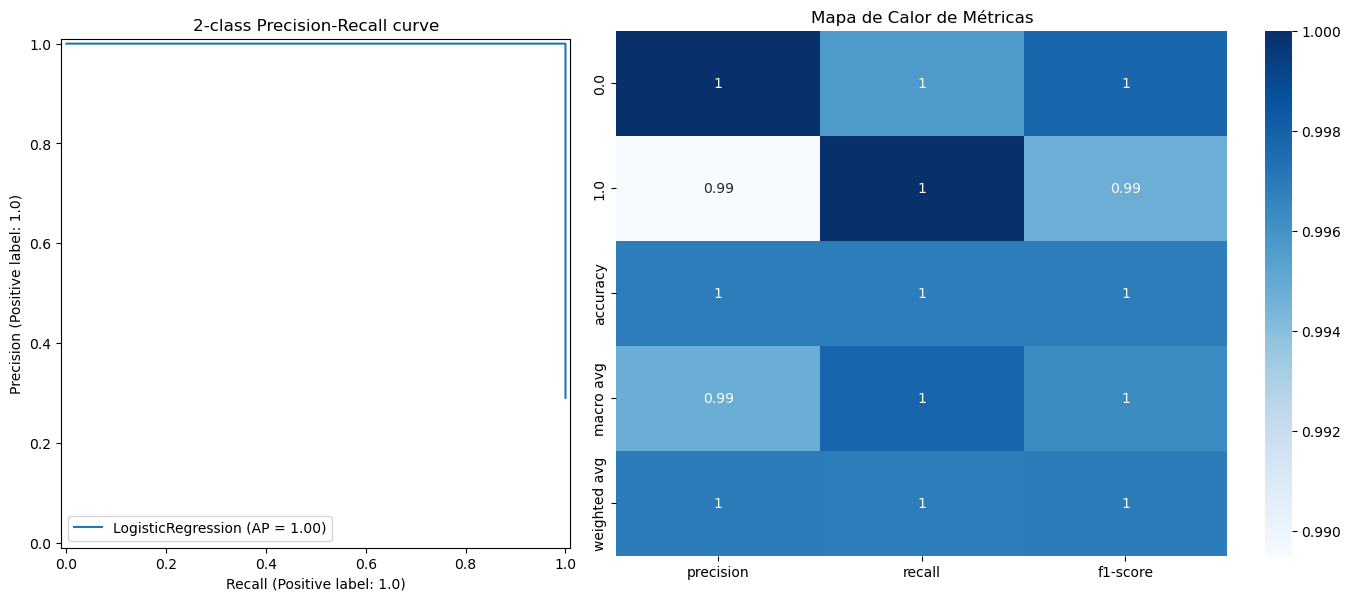

In [45]:
# Create logistic regression model object
logistic_reg_model = LogisticRegression()

# Hyper params from linear regression model
logistic_reg_params_grid = {
    'classify__penalty': ['l1', 'l2', 'Elastic Net'],
    'classify__C': [0.1, 1, 10],
    'classify__fit_intercept': [True, False],
}

# obtains best params from linear regression model using grid search
logistic_reg_best_params_grid = grid_search_function(logistic_reg_model, param_grid=logistic_reg_params_grid, X_train=X_train, y_train=y_train)

# train lineal regression model with best params previous obtains with grid search 
logistic_reg_model = train(logistic_reg_model, best_params=logistic_reg_best_params_grid)

# evaluation lineal regression model
y_pred, report = test(logistic_reg_model, is_classification=True)

#### Bagging

**Modelo 1: Bosques aleatorios:**

In [46]:
# creo instancia del modelo random forest
random_forest_model = RandomForestClassifier()

# Parametros y rango de valores para el modelo de random forest
random_forest_params_grid = {
    'classify__max_depth': [None, 5, 10],
    'classify__min_samples_split': [2, 5, 10],
    'classify__min_samples_leaf': [1, 2, 4],
    'classify__ccp_alpha': [0.0, 0.1, 0.2]
}

In [47]:
# obtengo los mejores parametros desde grid search
random_forest_best_params_grid = grid_search_function(model= random_forest_model, param_grid=random_forest_params_grid, X_train=X_train, y_train=y_train)

In [48]:
# entreno el modelo con los mejores parametros previamente obtenidos
random_forest_model = train(random_forest_model, random_forest_best_params_grid)

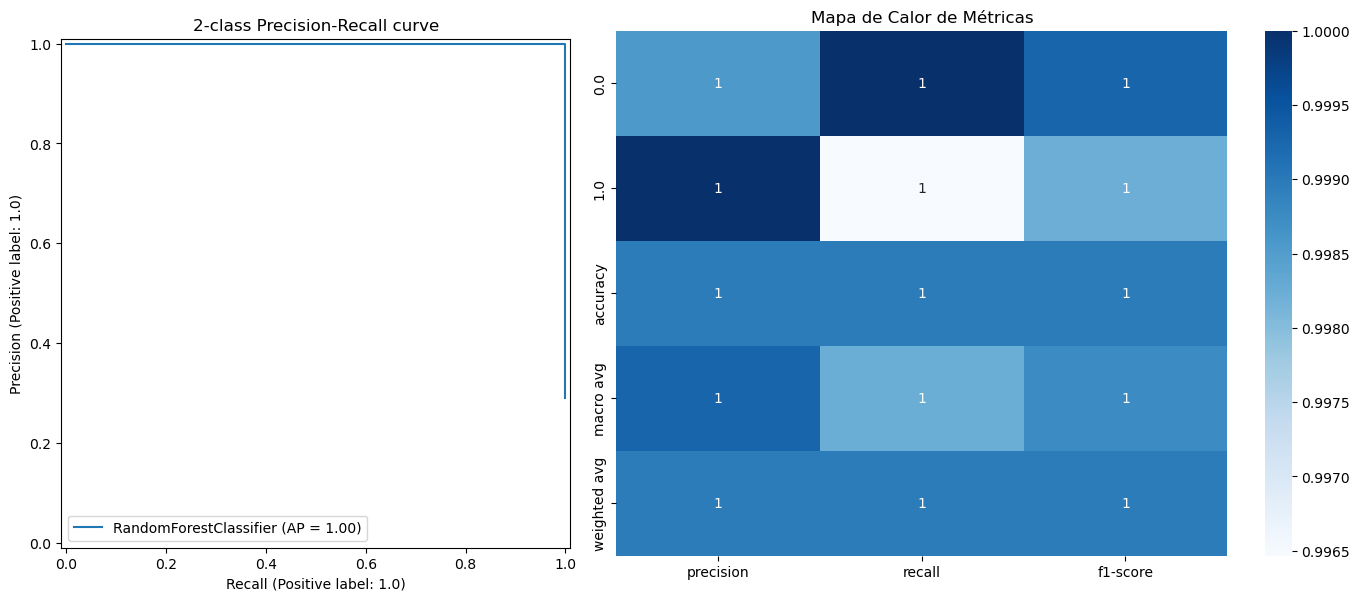

In [49]:
# obtengo las predicciones del modelo
y_pred, report = test(random_forest_model, is_classification=True)

**Modelo 2: Extra Trees**

In [50]:
# instancia del modelo extratrees
extra_trees_model = ExtraTreesClassifier()

# Define los parámetros a optimizar
extra_trees_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__max_depth': [None, 10, 20],
    'classify__min_samples_split': [2, 5],
    'classify__min_samples_leaf': [1, 2],
    'classify__max_features': ['auto', 'sqrt'],
    'classify__bootstrap': [False, True]
}

In [51]:
extra_trees_best_params_grid = grid_search_function(model= extra_trees_model, param_grid=extra_trees_params_grid, X_train=X_train, y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
61 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-pack

In [52]:
extra_trees_model = train(model=extra_trees_model, best_params=extra_trees_best_params_grid)

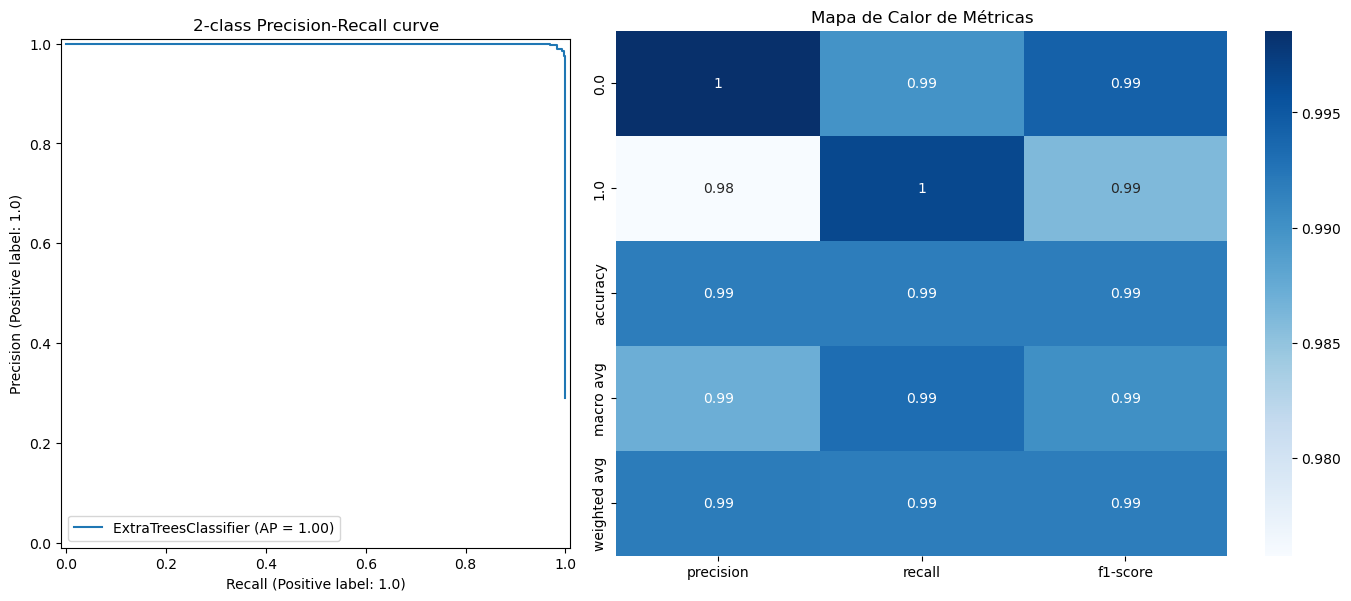

In [53]:
y_pred, report = test(model=extra_trees_model, is_classification=True)

#### Boosting

**Modelo 1: AdaBoost**

In [54]:
# Define el modelo base y el modelo AdaBoost
base_estimator = DecisionTreeClassifier()
AdaBoostClassifier_model = AdaBoostClassifier(estimator=base_estimator)

# Define los parámetros a optimizar
ada_boost_params_grid = {
    'classify__n_estimators': [50, 100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classify__estimator__max_depth': [1, 2, 3],
    'classify__algorithm': ['SAMME', 'SAMME.R']
}

In [55]:
ada_boost_best_params_grid = grid_search_function(model=AdaBoostClassifier_model, param_grid=ada_boost_params_grid, X_train=X_train,y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

In [56]:
AdaBoostClassifier_model = train(model=AdaBoostClassifier_model, best_params=ada_boost_best_params_grid)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


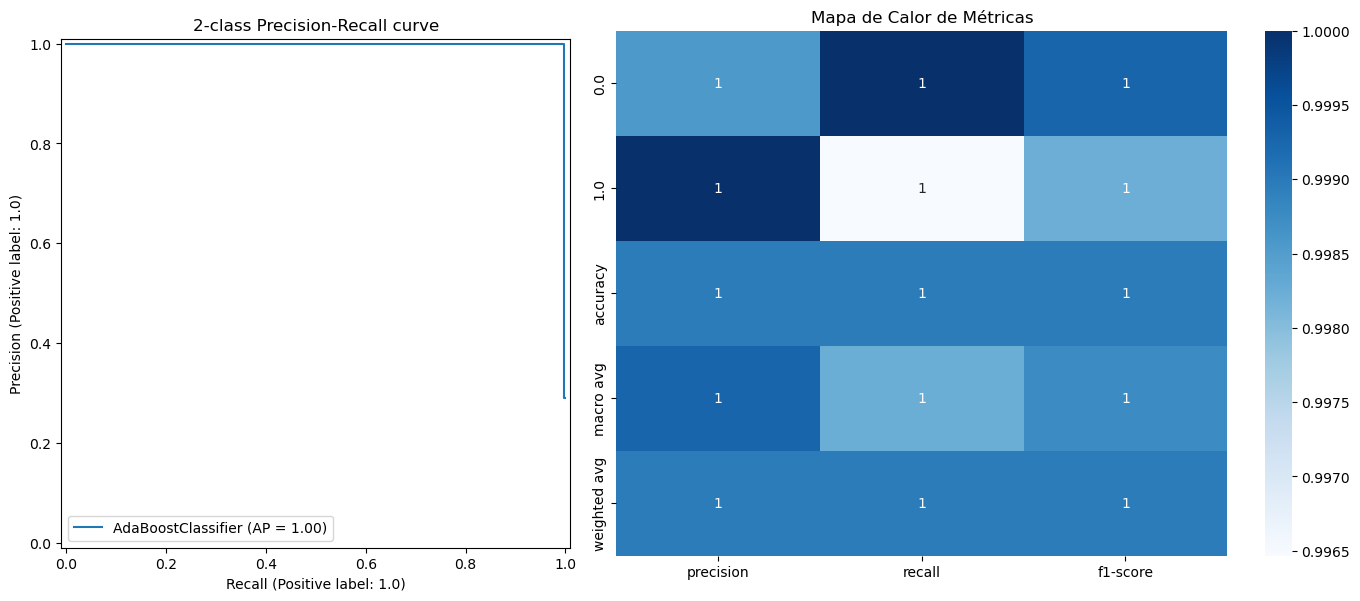

In [57]:
y_pred, report = test(model=AdaBoostClassifier_model, is_classification=True)

**Modelo 2: Stochastic Gradient Boosting**

In [58]:
# Definir el modelo
sgb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de parámetros
sgb_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__max_depth': [3, 6, 10],
    'classify__learning_rate': [0.01, 0.1, 0.2],
    'classify__subsample': [0.8, 1.0],
    'classify__ccp_alpha': [0, 0.1, 1]    # Regularización L1
}

In [59]:
sgb_best_params_grid = grid_search_function(model= sgb_model, param_grid=sgb_params_grid, X_train=X_train, y_train=y_train)

In [60]:
sgb_model = train(model=sgb_model, best_params=sgb_best_params_grid)

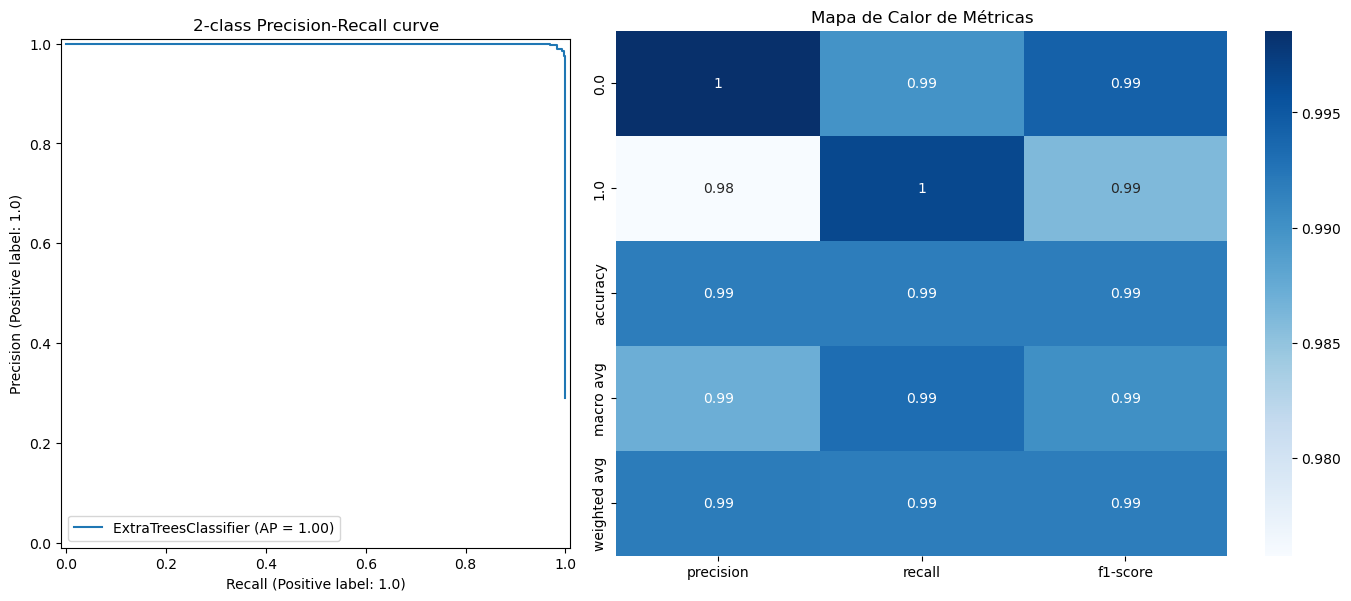

In [61]:
y_pred, report = test(model=extra_trees_model, is_classification=True)

#### Vooting

**Modelo 1: Hard Voting:**

In [62]:
# Crear un VotingClassifier con hard voting
voting_clf_hard_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', sgb_model)],
                              voting='hard') 

In [63]:
voting_clf_hard_model = train(model= voting_clf_hard_model)

AttributeError: VotingClassifier has none of the following attributes: predict_proba, decision_function.

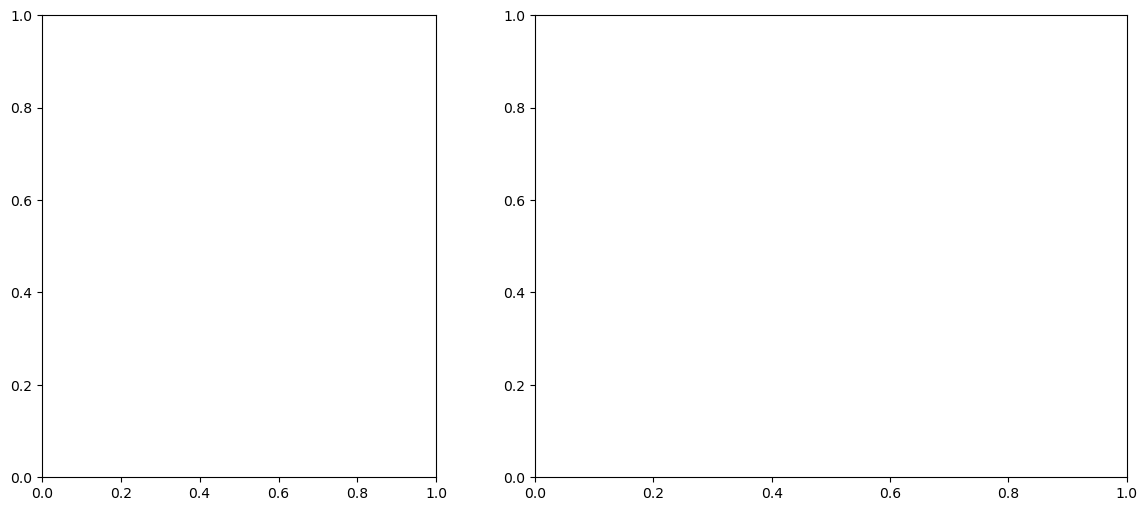

In [64]:
y_pred = test(model=voting_clf_hard_model, is_classification=True)

**Modelo 2: Soft Voting**

In [181]:
voting_clf_soft_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', sgb_model)],
                              voting='soft',
                              weights=[1, 1]) 

In [182]:
voting_clf_soft_model = train(model= voting_clf_soft_model)

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_40332/1121122864.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(classes, rotation=45)


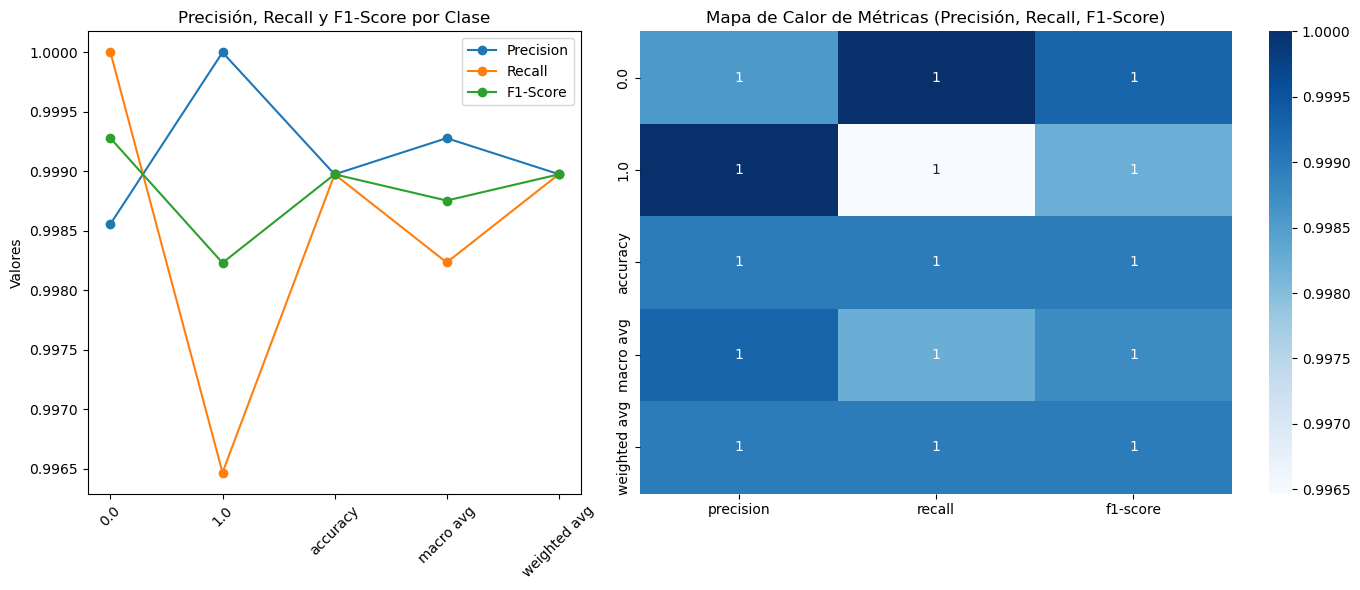

In [183]:
y_pred, report = test(model=voting_clf_soft_model, is_classification=True)

### Guardado del mejor modelo

In [184]:
# Guardar el modelo entrenado en un archivo .pkl
path_best_ml_model = '../models/subscription_status_extra_trees_model.pkl'
joblib.dump(extra_trees_model, path_best_ml_model)

['../models/subscription_status_extra_trees_model.pkl']

### Observaciones de esta etapa:

..